In [1]:
import polaris as po
print(po.__version__)
import numpy as np
import pandas as pd
from rdkit import Chem
import zipfile
import fsspec
import numpy as np
from tqdm import tqdm
import fastpdb
import datamol as dm

from tempfile import TemporaryDirectory
from pathlib import Path
import pymol
import base64
from rdkit import Chem


from rdkit.Chem import rdFMCS
# calculate rmsd between two molecules
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
import os

/home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.11.7


In [2]:
import spyrmsd

In [3]:
competition = po.load_competition("asap-discovery/antiviral-ligand-poses-2025")


[2025-02-24 21:13:13] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=967475;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=625059;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.7).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=785786;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=96957;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/dataset/_base.py#182\182]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

In [4]:
# competition.cache()

In [5]:
train, test = competition.get_train_test_split()

In [6]:
# Convert list of tuples to list of dictionaries
data_list = []
for data_dict, rdkit_object in train:
    data_dict['rdkit_object'] = rdkit_object
    data_list.append(data_dict)

# Convert to DataFrame
df = pd.DataFrame(data_list)

In [7]:

df_test = pd.DataFrame(test)

In [8]:
df_test['Protein Label'].value_counts()

Protein Label
SARS-CoV-2 Mpro    98
MERS-CoV Mpro      97
Name: count, dtype: int64

In [9]:
# modify the protein label SARS-CoV-2 Mpro  to SARS-CoV-2-Mpro
df_test['Protein Label'] = df_test['Protein Label'].replace('SARS-CoV-2 Mpro', 'SARS-CoV-2-Mpro')
df_test['Protein Label'] = df_test['Protein Label'].replace('MERS-CoV Mpro', 'MERS-CoV-Mpro')

In [10]:
df_test['Protein Label'].value_counts()

Protein Label
SARS-CoV-2-Mpro    98
MERS-CoV-Mpro      97
Name: count, dtype: int64

In [11]:
# show me index 187
df_test.iloc[187]

CXSMILES            CCn1nccc1CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@...
Protein Label                                         SARS-CoV-2-Mpro
Chain B Sequence    SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
Chain A Sequence    SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
Name: 187, dtype: object

In [44]:
# import yaml

# def create_pocket_yaml(protein_a_sequence, protein_b_sequence, ligand_smiles, output_file):
#     data = {
#         'sequences': [
#             {
#                 'protein': {
#                     'id': ['A1'],
#                     'sequence': protein_a_sequence
#                 }
#             },
#             {
#                 'protein': {
#                     'id': ['B1'],
#                     'sequence': protein_b_sequence
#                 }
#             },
#             {
#                 'ligand': {
#                     'smiles': ligand_smiles,
#                     'id': ['L1']
#                 }
#             }
#         ]
#     }

#     with open(output_file, 'w') as file:
#         yaml.dump(data, file, default_flow_style=False)

In [28]:
df_test['MOL'] = df_test['CXSMILES'].apply(Chem.MolFromSmiles)

In [29]:
df_test

,CXSMILES,Protein Label,Chain B Sequence,Chain A Sequence,Predicted Pose,MOL
0,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f8b805d4350>,<rdkit.Chem.rdchem.Mol object at 0x7f8b755c3060>
1,COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cc1,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f8b805d71b0>,<rdkit.Chem.rdchem.Mol object at 0x7f8b755c1930>
2,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SARS-CoV-2-Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f8b80465620>,<rdkit.Chem.rdchem.Mol object at 0x7f8b755c18c0>
3,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f8b805d7300>,<rdkit.Chem.rdchem.Mol object at 0x7f8b755c1a10>
4,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1ccnnc1)C(=O)N(c1c...,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f8b805d47b0>,<rdkit.Chem.rdchem.Mol object at 0x7f8b755c2c70>
...,...,...,...,...,...,...
190,CNS(=O)(=O)OCC(=O)N[C@@H](C)c1cc(Cl)cc(-c2ccc(...,SARS-CoV-2-Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f8b805d6a40>,<rdkit.Chem.rdchem.Mol object at 0x7f8b752a4200>
191,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SARS-CoV-2-Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f8b805d4120>,<rdkit.Chem.rdchem.Mol object at 0x7f8b752a4270>
192,O=C(Cc1cncc2ccccc12)NCc1cccc(Cl)c1,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f8b804e7290>,<rdkit.Chem.rdchem.Mol object at 0x7f8b752a42e0>
193,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SARS-CoV-2-Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,<rdkit.Chem.rdchem.Mol object at 0x7f8b805d6c00>,<rdkit.Chem.rdchem.Mol object at 0x7f8b752a4350>


In [14]:
# # Use iterrows on df_test to create the yaml files
# for index, row in df_test.iterrows():
 
#     protein_a_sequence = row['Chain A Sequence']
#     protein_b_sequence = row['Chain B Sequence']
#     ligand_smiles = dm.to_smiles(row['MOL'])
    
#     output_file =  yaml_test_folder / f'seq_{index}.yaml'
#     print(output_file)
#     create_pocket_yaml(protein_a_sequence, protein_b_sequence, ligand_smiles, output_file)

In [12]:
source = Path("./")
train_predicted = Path("./boltz_results_train_fasta_subset/predictions")
test_predicted = Path("./boltz_results_test_fasta_old/predictions")
reference = Path("./reference_structures")
test_ligand_outputs = Path("./test_ligand_outputs")
train_ligand_outputs = Path("./train_ligand_outputs")

In [13]:
df['Protein Label'].value_counts()

Protein Label
SARS-CoV-2 Mpro    770
Name: count, dtype: int64

In [14]:
# rename protein label SARS-CoV-2 Mpro  to SARS-CoV-2-Mpro 
df['Protein Label'] = df['Protein Label'].replace('SARS-CoV-2 Mpro', 'SARS-CoV-2-Mpro')

In [49]:
# def create_fasta_file(df, dir_name):
#     os.makedirs(dir_name, exist_ok=True)
#     for i, row in df.iterrows():
  
#         chain_a = row['Chain A Sequence']
#         chain_b = row['Chain B Sequence']
#         chain_cx = dm.to_smiles(row['MOL'])
       
#         with open(f"{dir_name}/seq_{i}.fasta", "w") as f:
#             f.write(f">A|protein|\n{chain_a}\n")
#             f.write(f">B|protein|\n{chain_b}\n")
#             f.write(f">E|smiles\n{chain_cx}\n")
            
# create_fasta_file(df_test, "test_fasta")


In [243]:
def pymol_align(index, row, output):
    # Let's reset! Just to be sure.
    pymol.cmd.delete("all")

    # Load the reference and mobile structure
    # ref_path = reference / f"complex_{index}.pdb"
    ref_path = reference / row['Protein Label'] / "complex.pdb"
    print(ref_path)
    target_path = train_predicted / f'seq_{index}' / f'seq_{index}_model_0.cif'
    print(target_path)
    pymol.cmd.load(target_path, "predicted")
    pymol.cmd.load(ref_path, "reference")

    # Corrupt the mobile protein
    # pymol.cmd.rotate("x", 90, selection="mobile")
    # Compute the RMSD

    # Align the mobile protein to the reference
    pymol.cmd.align(
    "polymer and name CA and predicted",
    "polymer and name CA and reference",
    quiet=0,
    )
 
    pymol.cmd.select('ligands_predicted', 'predicted and not polymer')

  

    # Export the ligand as a Mol2 file (or any other format RDKit can read)
    pymol.cmd.save(output / f'ligand_{index}.mol2', 'ligands_predicted')


# def ligand_compare(index):
#     # Get the Reference from df
#     ref_ligand = df.iloc[index]['rdkit_object']
#     ref_ligand = Chem.RemoveHs(ref_ligand)
    
#     # Get the Predicted ligand from Pymol
#     pred_ligand = Chem.MolFromMol2File(ligand_output / f'ligand_{index}.mol2')
#     pred_ligand = Chem.RemoveHs(pred_ligand)
    
#     mols = [ref_ligand, pred_ligand]
#     mcs =rdFMCS.FindMCS(mols,threshold=0.8,completeRingsOnly=True,ringMatchesRingOnly=True)
#     # align everything to the first molecule
#     patt = Chem.MolFromSmarts(mcs.smartsString)
#     refMol = mols[0]
#     refMatch = refMol.GetSubstructMatch(patt)
    
 
#     mv = pred_ligand.GetSubstructMatch(patt)
#     rms = AllChem.CalcRMS(pred_ligand,refMol,map=[list(zip(mv,refMatch))])
#     return rms
    
    
    
  





  
    
    

In [244]:
#  do iter rows in df_test
for i, row in df.iterrows():
    try:
        pymol_align(i, row, train_ligand_outputs)
    except:
        continue
    # rms = ligand_compare(i)
    # print(f"RMSD for {i} is {rms}")

reference_structures/SARS-CoV-2-Mpro/complex.pdb
boltz_results_train_fasta_subset/predictions/seq_0/seq_0_model_0.cif
 Match: read scoring matrix.
 Match: assigning 608 x 603 pairwise scores.
 MatchAlign: aligning residues (608 vs 603)...
 MatchAlign: score 3204.000
 ExecutiveAlign: 600 atoms aligned.
 ExecutiveRMS: 5 atoms rejected during cycle 1 (RMSD=1.34).
 ExecutiveRMS: 28 atoms rejected during cycle 2 (RMSD=0.70).
 ExecutiveRMS: 18 atoms rejected during cycle 3 (RMSD=0.59).
 ExecutiveRMS: 14 atoms rejected during cycle 4 (RMSD=0.55).
 ExecutiveRMS: 9 atoms rejected during cycle 5 (RMSD=0.53).
 Executive: RMSD =    0.511 (526 to 526 atoms)
reference_structures/SARS-CoV-2-Mpro/complex.pdb
boltz_results_train_fasta_subset/predictions/seq_1/seq_1_model_0.cif
 Match: read scoring matrix.
 Match: assigning 608 x 603 pairwise scores.
 MatchAlign: aligning residues (608 vs 603)...
 MatchAlign: score 3204.000
 ExecutiveAlign: 600 atoms aligned.
 ExecutiveRMS: 6 atoms rejected during cycle

In [15]:
def mask_nan(y_true, y_pred):
    mask = ~np.isnan(y_true)
    y_true = np.array(y_true)[mask]
    y_pred = np.array(y_pred)[mask]
    return y_true, y_pred


def mol_has_3D(mol):
    try:
        mol.GetConformer()
    except ValueError:
        raise ValueError("Cannot get conformer for molecule, is likely 2D")

    if not mol.GetConformer().Is3D():
        raise ValueError("Molecule is not 3D")

In [44]:
from spyrmsd.molecule import Molecule
from spyrmsd.rmsd import rmsdwrapper

In [47]:
def eval_poses(preds: list[Chem.Mol], refs: list[Chem.Mol], cutoff=2.0):
    """
    Evaluate the poses of the predicted molecules against the reference molecules.

    Calculates the % correct with respect to the RMSD cutoff value.

    Parameters
    ----------
    preds : list[Chem.Mol]
        List of predicted molecules.
    refs : list[Chem.Mol]

    cutoff : float
        The cutoff value for the RMSD value. Default is 2.0.

    Returns
    -------
    Tuple[np.ndarray, float]
        Returns a tuple of the RMSD values and the percentage of RMSD values less than the cutoff

    """

    if len(preds) != len(refs):
        raise ValueError("mismatched lengths in preds vs references")

    # find symm corrected  heavy atom RMSDs
    rmsds = []
    i = 0
    for pred, ref in zip(preds, refs):
       
        # Check the input
        mol_has_3D(pred)
        mol_has_3D(ref)
        if pred.GetNumHeavyAtoms() != ref.GetNumHeavyAtoms():
            
            raise ValueError("mismatched number of atoms")

        # Compute RMSD
        
        pred_spy = Molecule.from_rdkit(pred)
        ref_spy = Molecule.from_rdkit(ref)
        print(i)
        rmsd = rmsdwrapper(ref_spy, pred_spy, symmetry=True, strip=True)
        rmsds.extend(rmsd)
        i += 1

    rmsds = np.asarray(rmsds)

    # calculate % less than cutoff
    mask = rmsds <= cutoff

    correct = sum(mask)
    prob = (correct / rmsds.shape[0]) * 100

    collect = {}
    collect["rmsd_mean"] = np.mean(rmsds)
    collect["rmsd_min"] = np.min(rmsds)
    collect["rmsd_q1"] = np.quantile(rmsds, 0.25)
    collect["rmsd_median"] = np.quantile(rmsds, 0.5)
    collect["rmsd_q3"] = np.quantile(rmsds, 0.75)
    collect["rmsd_max"] = np.max(rmsds)
    collect["rmsd_coverage"] = prob

    return collect


In [35]:
mol = []
# read all molecules in ligand output
for i in range(99):
    try:
        mol.append(Chem.MolFromMol2File(train_ligand_outputs / f'ligand_{i}.mol2', sanitize=False))
    except:
        mol.append(None)
    

[21:18:23] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[21:18:23] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[21:18:23] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[21:18:23] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[21:18:23] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[21:18:23] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[21:18:23] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[21:18:23] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[21:18:23] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[21:18:23] predicted: Warnin

In [252]:
df_subset = df.iloc[:99]

In [254]:
df_subset['Predicted'] = mol

/tmp/ipykernel_906792/1158412970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Predicted'] = mol


In [48]:
df_test['Sample'] = df_test['MOL'].apply(lambda x:  dm.conformers.generate(x, n_confs=1))

In [61]:
eval_poses(df_test['Predicted Pose'], df_test['Sample'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


{'rmsd_mean': 24.315147101079052,
 'rmsd_min': 22.30890413911456,
 'rmsd_q1': 23.84537353382538,
 'rmsd_median': 24.3517729256532,
 'rmsd_q3': 24.809173194895948,
 'rmsd_max': 27.706277940170242,
 'rmsd_coverage': 0.0}

In [62]:
def serialize_rdkit_mol(mol: Chem.Mol): 
    props = Chem.PropertyPickleOptions.AllProps
    mol_bytes = mol.ToBinary(props)
    return base64.b64encode(mol_bytes).decode('ascii')  

# y_pred_serialized = [serialize_rdkit_mol(mol) for mol in y_pred]

In [26]:
mol = []
# read all molecules in ligand output
for i in range(195):
    try:
        mol.append(Chem.MolFromMol2File(test_ligand_outputs / f'ligand_{i}.mol2', sanitize=False))
    except:
        mol.append(None)
    

[20:57:41] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:41] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:41] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:41] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:41] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:41] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:41] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:41] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:42] predicted: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:42] predicted: Warnin

In [17]:
sars = Chem.SDMolSupplier("minimized/sars_minimized_ligands.sdf",sanitize=False)
mers = Chem.SDMolSupplier("minimized/mers_minimized_ligands.sdf",sanitize=False)

In [18]:
# SARS-CoV-2-Mpro find indices in df _testi
s_index = df_test[df_test["Protein Label"] == "SARS-CoV-2-Mpro"].index
m_index = df_test[df_test["Protein Label"] == "MERS-CoV-Mpro"].index

In [19]:
mols_with_proper_index = {}

In [20]:
for index, molindex in enumerate(s_index):
    mols_with_proper_index[f'ligand_{molindex}'] = sars[index]

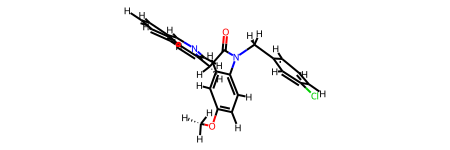

In [21]:
for index, molindex in enumerate(m_index):
    mols_with_proper_index[f'ligand_{molindex}'] = mers[index]
    
mols_with_proper_index['ligand_1']

In [22]:
# sort dictionary by key
mols_with_proper_index = dict(sorted(mols_with_proper_index.items()))

In [23]:
df_test

,CXSMILES,Protein Label,Chain B Sequence,Chain A Sequence
0,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...
1,COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cc1,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...
2,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SARS-CoV-2-Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
3,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...
4,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1ccnnc1)C(=O)N(c1c...,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...
...,...,...,...,...
190,CNS(=O)(=O)OCC(=O)N[C@@H](C)c1cc(Cl)cc(-c2ccc(...,SARS-CoV-2-Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
191,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SARS-CoV-2-Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
192,O=C(Cc1cncc2ccccc12)NCc1cccc(Cl)c1,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...
193,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SARS-CoV-2-Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...


In [24]:
# add a empty column to df_test
df_test['Predicted Pose'] = np.nan

In [25]:
# go through each row in df_test and add the predicted pose
for index, row in df_test.iterrows():

    df_test.at[index, 'Predicted Pose'] = mols_with_proper_index[f'ligand_{index}']

/tmp/ipykernel_935829/4265409299.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<rdkit.Chem.rdchem.Mol object at 0x7f8b805d4350>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.at[index, 'Predicted Pose'] = mols_with_proper_index[f'ligand_{index}']


In [30]:
df_test['match'] = df_test.apply(lambda x: dm.same_mol(x['MOL'], x['Predicted Pose']), axis=1)

[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:17:39] tetra

In [31]:
df_test['match'].value_counts()

match
True     134
False     61
Name: count, dtype: int64

In [208]:
# what is iundex of all failed matches
failed_match = df_test[df_test['match'] == False]

In [209]:
failed_match['Protein Label'].value_counts()

Protein Label
MERS-CoV-Mpro      34
SARS-CoV-2-Mpro    27
Name: count, dtype: int64

In [36]:
# save the failed matches to a smi file with corresponding 
# select all failed matched with protein label SARS-CoV-2-Mpro
sars_failed_match = failed_match[failed_match['Protein Label'] == "SARS-CoV-2-Mpro"]
# save CXSMILES to a file
sars_failed_match['CXSMILES'].to_csv('sars_failed_match.smi', index=False)

In [ ]:
mars_failed_match = failed_match[failed_match['Protein Label'] == "MERS-CoV-Mpro"]
# save CXSMILES to a file
# mars_failed_match['CXSMILES'].to_csv('mars_failed_match.smi', index=False)

In [228]:
mars_failed_match['CXSMILES']

3      CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...
10     C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC#N)C...
11     CCC(=O)[N@H+]1CCCc2c(N(Cc3cccc(Cl)c3)C(=O)Cc3c...
24     C[C@H]1C[NH+](CCN2C[C@@]3(C(=O)N(c4cncc5ccccc4...
32     C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[N@@...
33     C[C@H]1C[N@H+](CCN2C[C@@]3(C(=O)N(c4cncc5ccccc...
35      C[C@H]1C[C@H](c2ccccc2)N(C(=O)Cc2cncc3ccccc23)C1
40     O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@H](C(=O)Nc2cncc3cc...
44     C[C@H]1C[N@@H+](CCN2C[C@@]3(C(=O)N(c4cncc5cccc...
47     C[NH2+]CCN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@...
54     O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2...
56     CC[C@H]1C[C@@H](C(F)(F)F)CCN1C(=O)Cc1cncc2ccccc12
57     C[NH2+]CCN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@...
58     C[NH2+]CCN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@...
61     C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[N@H...
68     N#CCc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23...
75     C[NH2+]CCN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@...
92     CNC(=O)CN1C[C@@]2(C(=O)N

In [229]:
df_test[(df_test['Protein Label'] == "MERS-CoV-Mpro") & (df_test['match'] == False)]['CXSMILES']

185    O=C(Cc1cncc2ccccc12)N1C=CC=CC=C[C@H]1c1ccccc1
Name: CXSMILES, dtype: object

In [51]:
def fix_unmatched(p0_file,p1_file, protein,rm,rn):
    # read a sdf file
    sars_p0 = Chem.SDMolSupplier(p0_file,sanitize=False)
    sars_p1 = Chem.SDMolSupplier(p1_file,sanitize=False)

    # create a pandas df with sars_p0 name and LF dg
    sars_p0_df = pd.DataFrame()
    sars_p0_df['name'] = [mol.GetProp('_Name') for mol in sars_p0]
    sars_p0_df['LF dg'] = [mol.GetProp('LF dG') for mol in sars_p0]
    sars_p0_df['Structure_p0'] = [mol for mol in sars_p0]

    # create a pandas df with sars_p0 name and LF dg
    sars_p1_df = pd.DataFrame()
    sars_p1_df['name'] = [mol.GetProp('_Name') for mol in sars_p1]
    sars_p1_df['LF dg'] = [mol.GetProp('LF dG') for mol in sars_p1]
    sars_p1_df['Structure_p1'] = [mol for mol in sars_p1]


    sars_p1_df = sars_p1_df.sort_values(by='name')
    sars_p1_df = sars_p1_df.rename(columns={'LF dg': 'LF dg p1'})
    sars_p1_df['name'] = sars_p1_df['name'].str[:-rn]

    sars_p0_df = sars_p0_df.sort_values(by='name')
    sars_p0_df = sars_p0_df.rename(columns={'LF dg': 'LF dg p0'})


    # merge sars_p0_df and sars_p1_df by name and reset index
    sars_merged = pd.merge(sars_p0_df, sars_p1_df, on='name').reset_index(drop=True)
    sars_merged['better_pocket'] = np.where(sars_merged['LF dg p0'] > sars_merged['LF dg p1'], 'p0', 'p1')
    sars_merged['final_structure'] = np.where(sars_merged['LF dg p0'] > sars_merged['LF dg p1'], sars_merged['Structure_p0'], sars_merged['Structure_p1'])
    # in name of sars_merged , remove _D and sars_failed_match:
    sars_merged['name'] = sars_merged['name'].str.replace('_D', '')
    sars_merged['name'] = sars_merged['name'].str.replace(rm, '')
    sars_merged['name'] = sars_merged['name'].apply(int)
    sars_merged = sars_merged.sort_values(by='name')

    # find the index of failed matches in df_test that are SARS-CoV-2-Mpro
    sars_failed_match_index = df_test[(df_test['Protein Label'] == protein) & (df_test['match'] == False)].index
    sars_merged['key'] = sars_failed_match_index

    df_test['Predicted Pose Copy'] = df_test['Predicted Pose']

    # go through sars_merged, the key is the index of failed matches in df_test and replace MOL with final_structure
    for index, row in sars_merged.iterrows():
        df_test.at[row['key'], 'Predicted Pose'] = row['final_structure']
        
    df_test['match'] = df_test.apply(lambda x: dm.same_mol(x['MOL'], x['Predicted Pose']), axis=1)

In [52]:
# index of all match = false for SARS-CoV-2-Mpro
df_test[(df_test['Protein Label'] == "SARS-CoV-2-Mpro") & (df_test['match'] == False)].index

Index([ 12,  18,  19,  22,  25,  31,  36,  49,  50,  52,  77,  78,  88,  89,
        95, 108, 111, 115, 127, 136, 138, 142, 155, 170, 171, 175, 194],
      dtype='int64')

In [53]:
fix_unmatched("docked_flare_pocket_0.sdf", "docked_flare_pocket_1.sdf", "SARS-CoV-2-Mpro",'sars_failed_match:',2)

[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:43] tetra

In [54]:
fix_unmatched("docked_flare_pocket_0_mers.sdf", "docked_flare_pocket_1_mers.sdf", "MERS-CoV-Mpro",'mars_failed_match:',4)

[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetrahedral chirality on atom with <3 or >4 neighbors will be ignored.
[21:22:44] tetra

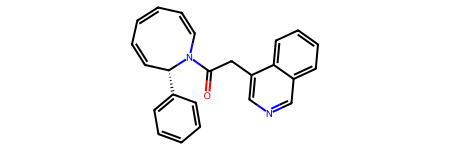

In [55]:
df_test[(df_test['Protein Label'] == "MERS-CoV-Mpro") & (df_test['match'] == False)]['MOL'].values[0]

In [56]:
p =df_test[(df_test['Protein Label'] == "MERS-CoV-Mpro") & (df_test['match'] == False)]['Predicted Pose'].values[0]

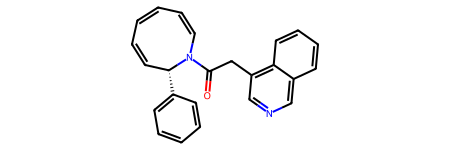

In [57]:

Chem.MolFromSmiles(Chem.MolToSmiles(p))

In [58]:
dm.same_mol(p,df_test[(df_test['Protein Label'] == "MERS-CoV-Mpro") & (df_test['match'] == False)]['MOL'].values[0])

False

In [59]:
dm.to_inchikey(p)

'MCCGVVMSKBCSRH-IGXKNELUSA-N'

In [240]:
dm.to_inchikey(df_test[(df_test['Protein Label'] == "MERS-CoV-Mpro") & (df_test['match'] == False)]['MOL'].values[0])

'MCCGVVMSKBCSRH-QHCPKHFHSA-N'

In [60]:
df_test[df_test['match'] == False]

,CXSMILES,Protein Label,Chain B Sequence,Chain A Sequence,Predicted Pose,MOL,match,Sample,Predicted Pose Copy
185,O=C(Cc1cncc2ccccc12)N1C=CC=CC=C[C@H]1c1ccccc1,MERS-CoV-Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,<rdkit.Chem.rdchem.Mol object at 0x7f8b745a1380>,<rdkit.Chem.rdchem.Mol object at 0x7f8b752a3f40>,False,<rdkit.Chem.rdchem.Mol object at 0x7f8b746f1460>,<rdkit.Chem.rdchem.Mol object at 0x7f8b804e70d0>


In [181]:
index

194

In [188]:
df_test.iloc[index]['CXSMILES']

'C[C@@H]1COC[C@@]2(C1)NC(=O)N(c1cncc3ccccc13)C2=O'

In [ ]:
# save 

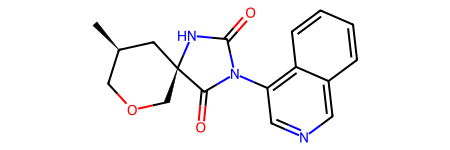

In [63]:
y_pred_serialized = [serialize_rdkit_mol(mol) for mol in df_test['Predicted Pose'].values]

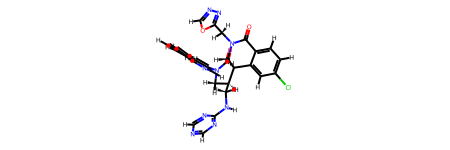

In [64]:
deserialized = Chem.Mol(base64.b64decode(y_pred_serialized[0].encode("ascii")))
deserialized

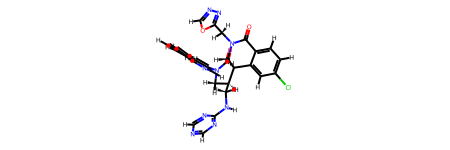

In [65]:
df_test['Predicted Pose'][0]

In [66]:
dm.same_mol(df_test['Predicted Pose'][0], deserialized)

True

In [67]:
df_test['ref heavy atoms'] = df_test['MOL'].apply(lambda x: x.GetNumHeavyAtoms())
df_test['pred heavy atoms'] = df_test['Predicted Pose'].apply(lambda x: x.GetNumHeavyAtoms())


In [68]:
df_test['num heavy atomns diff'] = df_test['ref heavy atoms'] - df_test['pred heavy atoms']

In [69]:
df_test['num heavy atomns diff'] = df_test['num heavy atomns diff'].astype(int)
df_test['num heavy atomns diff'].value_counts()

num heavy atomns diff
0    195
Name: count, dtype: int64

In [70]:
competition.submit_predictions(
    predictions=y_pred_serialized,
    prediction_name="Pose-Prediction-Intermediate-2",
    prediction_owner="auro",
    report_url="https://www.example.com", 
    # The below metadata is optional, but recommended.
    # github_url="https://github.com/polaris-hub/polaris",
    description="Pose prediction using Open source model as a starting checkpoint and compare performance.",
    # tags=["tutorial"],
    # user_attributes={"Framework": "RDKit", "Method": "Dummy Baseline"}
)

/home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[21:24:49]  Success: Submitting competition predictions                                               ]8;id=925639;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=46192;file:///home/s1905547/.conda/envs/boltzswan/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

In [69]:
# move the first ligand_i files from train_fasta to anothr folder
for i in range(100):
    try:
        os.rename( f'train_fasta/seq_{i}.fasta',  f'train_fasta_subset/seq_{i}.fasta')
    except:
        print(f"file {i} not found")